<h1>Executive Summary</h1>

This notebook forecast the number of views on the "Full moon" wikipedia page<br>
Data comes from wikipediatrend package in R which uses the wikipedia api<br>
    - Data from 2017 - 2020 with daily freqency

Data cleaning
    - Years before 2016 have zero views which were determined to be missing values <br>
    - 2014 and 2015 are the worst years and where removed from analysis <br>
        - 2014/2015 had missing values during the peak viewing times and therefore could not be ffilled <br>
    - Missing values where filled using forward fill (ffill) <br>
    - 2013 was then glued to 2016 in time <br>

Modeling was performed using an LSTM in keras with:<br>
    - 4 recurrent cells<br>
    - trained using 10 epochs<br>
    - mini batch size of 1<br>
    - adam optimizer<br>
    - mse was the value to minimize in training<br>
    
Validation down using Time-Series CV with a mean absolute scaled error<br>
    - mase ~25 once stable<br>
    - took 7 years to stabilize<br>

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.plotting.register_matplotlib_converters()

# Plotting style
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.dpi'] = 100

# Notebook setup
%matplotlib inline

<h2>Load Data</h2>

In [6]:
CWD = os.getcwd()
FULLMOON_DATA_PATH = os.path.join(CWD, 'data/moon_wiki_views.csv')

fullmoon = pd.read_csv(FULLMOON_DATA_PATH)
fullmoon.head()

,Unnamed: 0,language,article,date,views
0,1462,en,full_moon,2007-12-10,823
1,1463,en,full_moon,2007-12-11,726
2,1464,en,full_moon,2007-12-12,969
3,1465,en,full_moon,2007-12-13,821
4,1466,en,full_moon,2007-12-14,677


In [7]:
fullmoon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4410 non-null   int64 
 1   language    4410 non-null   object
 2   article     4410 non-null   object
 3   date        4410 non-null   object
 4   views       4410 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 172.4+ KB


<h3>Basic Data Cleaning</h3>

In [8]:
fullmoon['date'] = pd.to_datetime(fullmoon['date'])

<h2>Exploratory Data Analysis</h2>

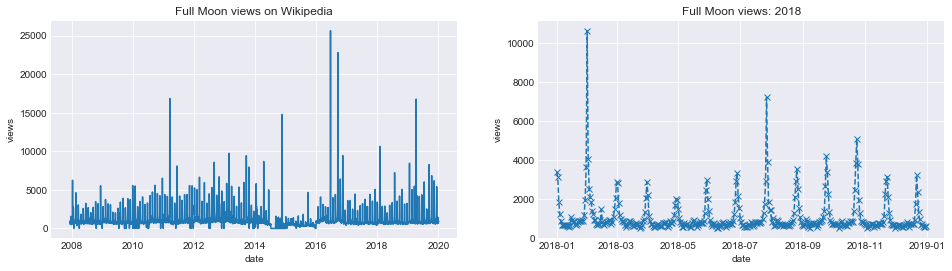

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(fullmoon['date'], fullmoon['views'])
axes[0].set_ylabel('views')
axes[0].set_xlabel('date')
axes[0].set_title('Full Moon views on Wikipedia')

axes[1].plot(fullmoon[(fullmoon['date'].dt.year >= 2018) & (fullmoon['date'].dt.year < 2019)]['date'], 
             fullmoon[(fullmoon['date'].dt.year >= 2018) & (fullmoon['date'].dt.year < 2019)]['views'], 'x--')
axes[1].set_ylabel('views')
axes[1].set_xlabel('date')
axes[1].set_title('Full Moon views: 2018');

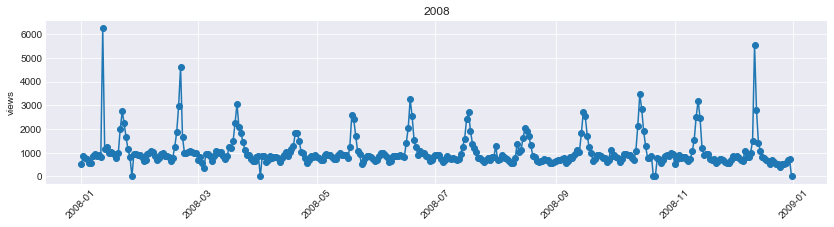

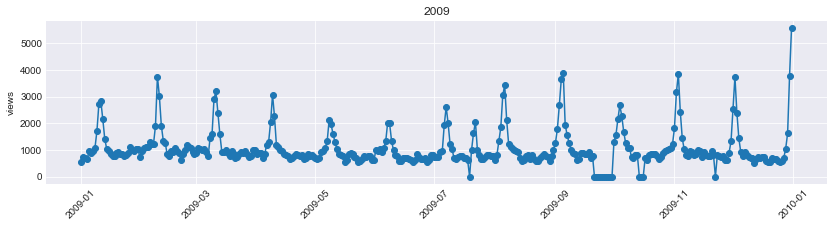

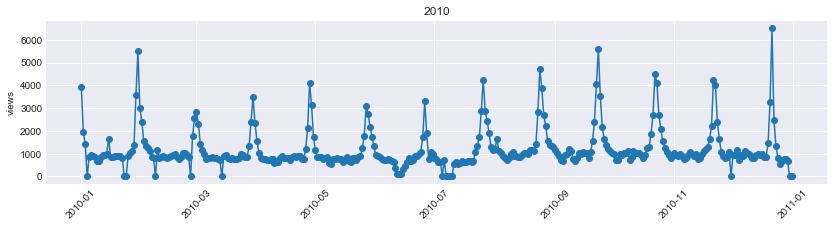

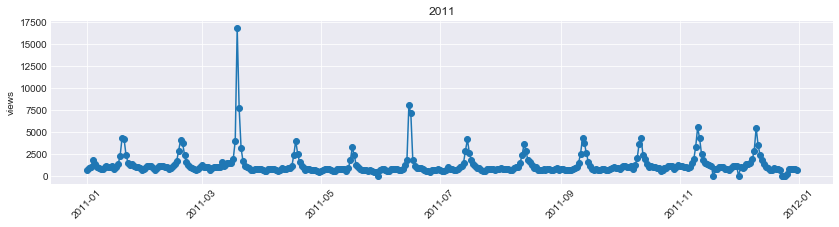

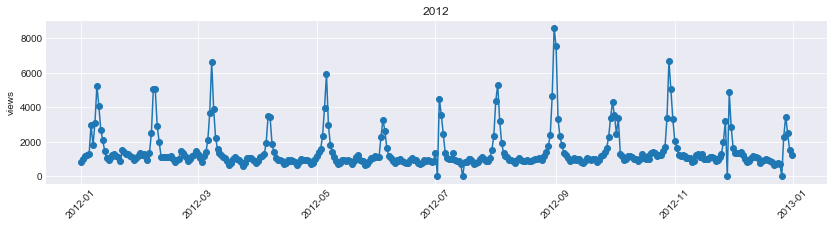

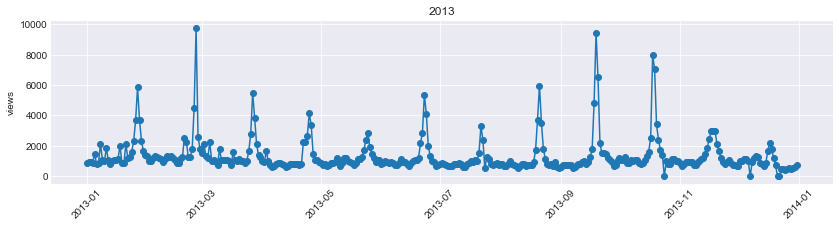

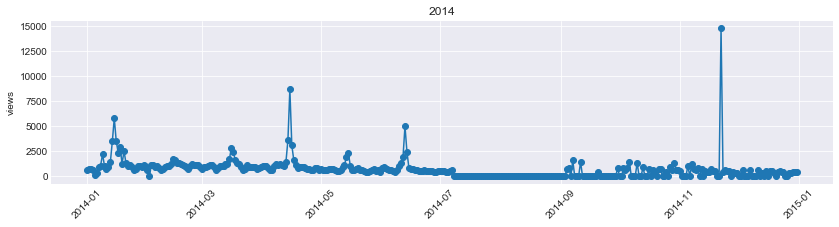

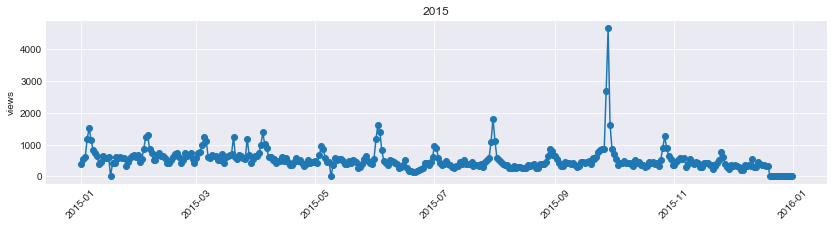

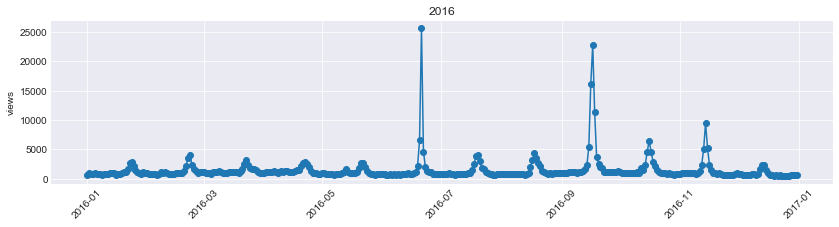

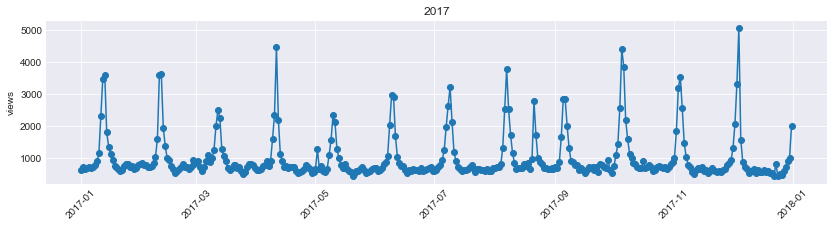

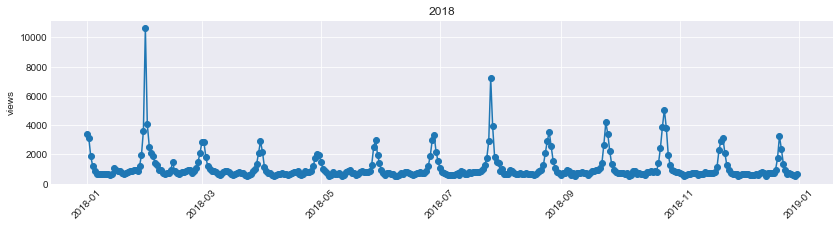

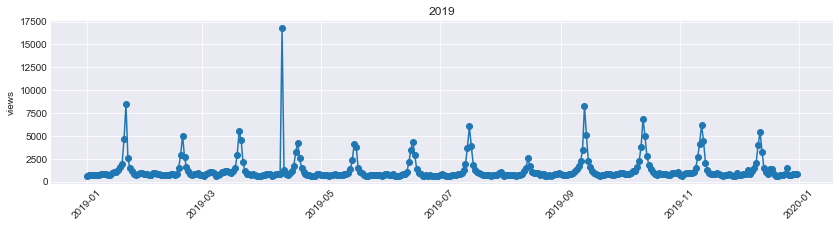

In [10]:
for add_years in range(20-8):
    plt.figure(figsize=(14, 3))
    year = 2008 + add_years
    plt.plot(fullmoon[fullmoon['date'].dt.year == year]['date'], fullmoon[fullmoon['date'].dt.year == year]['views'],
            'o-')
    plt.xticks(rotation=45)
    plt.title(year)
    plt.ylabel('views');

<h3>Views vs. Time</h3>

- Outliers with zero number of views
    - Mostly in 2014 and 2015
- About 12 peaks per year

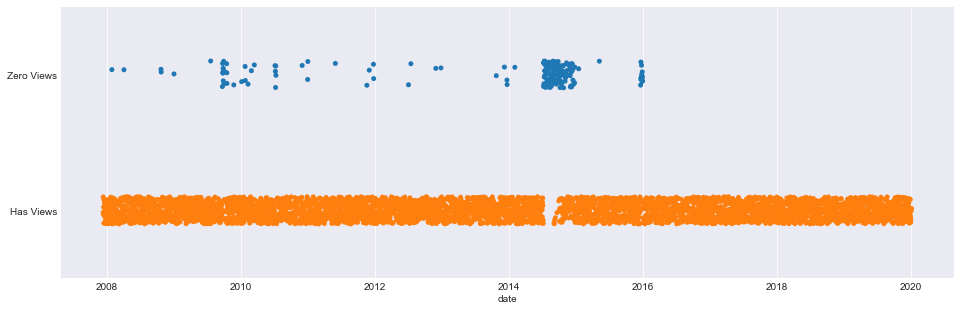

In [11]:
fullmoon['zero_view'] = fullmoon['views'].where(fullmoon['views'] == 0, 1)

fig, ax = plt.subplots(figsize=(16, 5))
sns.stripplot(x="date", y="zero_view", orient='h', data=fullmoon, ax=ax)
ax.set_yticklabels(labels=['Zero Views', 'Has Views'])
ax.set_ylabel('');

In [12]:
number_days_zero_views = 0
for idx, row in fullmoon[['date', 'views']].iterrows():
    i_date, i_views = 0, 1
    if row[i_views] == 0:
        number_days_zero_views += 1
        
print ('Number of Days with zero views: %i' % number_days_zero_views)

Number of Days with zero views: 178


<h3>Zero Views</h3>
    
- Years before 2016 have 0 view days
- 0 views are mistakes
- 2014-2015 are the worst 2 years


- Options: 
    - do not use those years
    - ignore 0 view days
    - smooth out 0 view days

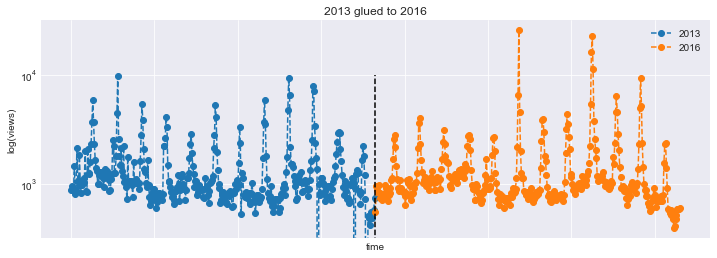

In [13]:
plt.figure(figsize=(12, 4))

plt.plot(np.arange(len(fullmoon[fullmoon['date'].dt.year == 2013])), 
         fullmoon[fullmoon['date'].dt.year == 2013]['views'], 'o--', label='2013')
plt.plot(np.arange(len(fullmoon[fullmoon['date'].dt.year == 2013]), 
                   len(fullmoon[fullmoon['date'].dt.year == 2013])
                   +len(fullmoon[fullmoon['date'].dt.year == 2016])), 
         fullmoon[fullmoon['date'].dt.year == 2016]['views'], 'o--', label='2016')
plt.plot([len(fullmoon[fullmoon['date'].dt.year == 2013]), len(fullmoon[fullmoon['date'].dt.year == 2013])], 
         [0, 10000], 'k--')
plt.ylabel('log(views)')
plt.yscale('log')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel('time')
plt.legend()
plt.title('2013 glued to 2016');

<h3>Removing 2014 & 2015</h3>

Gluing 2013 and 2016 together: There is a dip at the intersection.  Probably this will not matter too much

<h3>Data Cleaning</h3>
- Remove 2014 and 2015<br>
- Years before 2016 shift 2 years forward (i.e. 2013 -> 2015)<br>
- Forward fill 0.0 view days

In [14]:
fullmoon = fullmoon[(fullmoon['date'].dt.year != 2014) 
                    & (fullmoon['date'].dt.year != 2015)][['date', 'views']]
fullmoon['views'] = fullmoon['views'].mask(fullmoon['views']==0, np.nan)
fullmoon['views'] = fullmoon['views'].fillna(method='ffill')
fullmoon.reset_index(inplace=True)

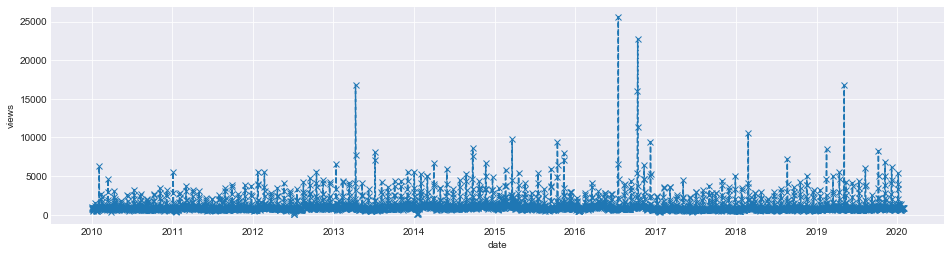

In [15]:
plt.figure(figsize=(16, 4))

fullmoon['views'].plot(marker='x', linestyle='--')
plt.xticks(np.arange(0, len(fullmoon), 365).tolist(), np.arange(2010, 2021).tolist())
plt.xlabel('date')
plt.ylabel('views');

TODO: check the number of peaks per year and the width of the peaks

<h2>Modeling</h2>

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
        
def PlotCV(x_train, y_train, y_pred, x_test, y_test, fcast):
    """Plot the CV results and forecast
    Typically used in a for loop when doing cross-validation
    """
    mape_test = 100*np.abs(y_test - fcast)/y_test
    mape_train = 100*np.abs(y_train - y_pred)/y_train
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 6))
    
    axes[0].plot(x_train, y_train, '--', label='train')
    axes[0].plot(x_train, y_pred, '--', label='predict')
    axes[0].plot(x_test, y_test, '--', label='test')
    axes[0].plot(x_test, fcast, '--', label='forecast')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylabel('views')
    axes[0].legend()
    
    axes[1].plot(x_train, mape_train, '--', label='in-sample')
    axes[1].plot(x_test, mape_test, '--', label='forecast')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45) 
    axes[1].set_ylabel('MAPE %')
    axes[1].set_yscale('log')
    axes[1].legend();

<h3>LSTM</h3>

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def Fit_LSTM(X, Y, n_neurons, n_epoch, batch_size=1):
    """Define an RNN with:
    n_lstm_layers and n_neurons per LSTM layer
    trained with n_epoch and a mini-batch size of batch_size
    
    Args: 
        X, Y (np.array)
        n_neurons, n_epoch, batch_size (int)
    Returns:
        lstm model (keras.models.Sequential)
    """
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, stateful=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_epoch):
        model.fit(X, Y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        #model.fit(X, Y, epochs=1, batch_size=batch_size, shuffle=False)
        model.reset_states()
    return model


def Error_Cal(y_train, y_test, y_forecast, error_type):
    """return mean absolute scaled error"""
    
    error = None
    if error_type == 'mase':
        in_sample_mae = 0
        for i in range(len(y_train)-1):
            in_sample_mae += abs(y_train[i] - y_train[i+1])
        in_sample_mae /= ( len(y_train)-1 )
    
        error = (np.abs(y_test - y_forecast)).sum()
        error /= len(y_test)
    
        error = error/in_sample_mae[0]
    
    elif error_type == 'mape':
        error = ( np.abs((y_test - y_forecast)/y_test) ).sum()
        error /= len(y_test)
        
    return error


def CV_LSTM(X, Y, n_years, n_neurons, n_epoch, batch_size=1, cv_plots=True):
    """Return the Cross Validation MASE (mean absolution scaled error) error
    MASE is calculated by forcasting at most 1 year into the future
    
    Plots the CV predictions as well
    
    Args: 
        X, Y (np.array)
        n_neurons, n_epoch, batch_size (int)
        n_years (int) number of years considered: n_splits = n_years-1
    Returns:
        rmses (List(float)): rmse of each CV split
    """
    
    cv_errors = {'mase':[], 'mape':[], 'rmse':[]}
    tscv = TimeSeriesSplit(n_splits=n_years-1)
    for train_indices, test_indices in tscv.split(X):
        y_train, y_test = Y[train_indices], Y[test_indices]
        x_train, x_test = X[train_indices], X[test_indices]
            
        fit_lstm = Fit_LSTM(x_train, y_train, n_neurons, n_epoch, batch_size)
        y_train_pred = fit_lstm.predict(y_train.reshape(y_train.shape[0], 
                                                        1, y_train.shape[1]), batch_size=1)
        y_forecast = fit_lstm.predict(y_test.reshape(y_test.shape[0], 
                                                     1, y_test.shape[1]), batch_size=1)
        
        mase = Error_Cal(y_train, y_test, y_forecast, 'mase')
        rmse = np.sqrt(mean_squared_error(y_test, y_forecast))
        mape = Error_Cal(y_train, y_test, y_forecast, 'mape')
        
        cv_errors['mase'].append(mase)
        cv_errors['rmse'].append(rmse)
        cv_errors['mape'].append(mape)

        if cv_plots:
            i_middle = len(x_train)
            i_last = i_middle + len(x_test)
            PlotCV(np.arange(len(x_train)), y_train, y_train_pred, 
                   np.arange(i_middle, i_last), y_test, y_forecast)
    
    return cv_errors

Using TensorFlow backend.


<h4>LSTM data preparation</h4>

In [23]:
#Setup input and output data
X = fullmoon['views'].values
Y = np.zeros((X.shape[0]-1, 1))
Y[:, 0] = X[1:]
X = X[:-1].reshape(-1, 1)

minmax_scaler = MinMaxScaler(feature_range=(0.001, 1))
X_scaled = minmax_scaler.fit_transform(X)
Y_scaled = minmax_scaler.transform(Y)

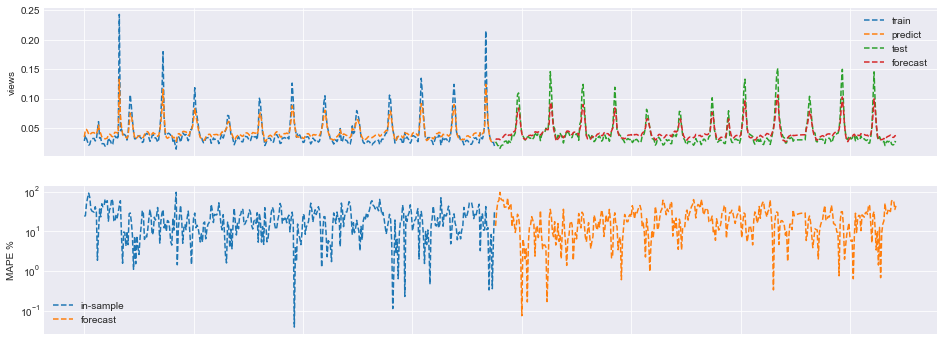

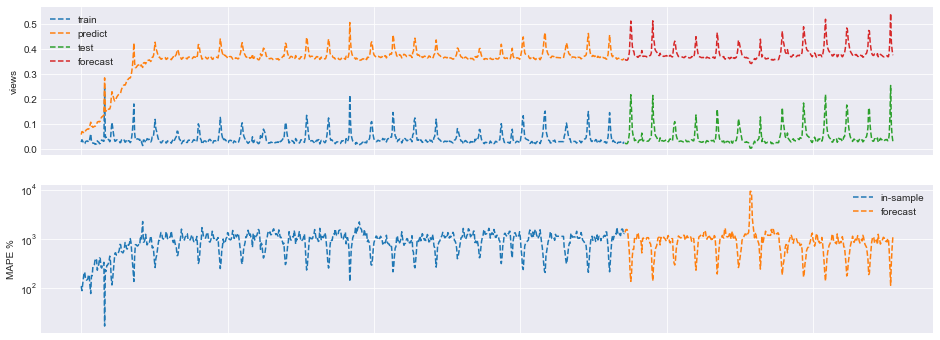

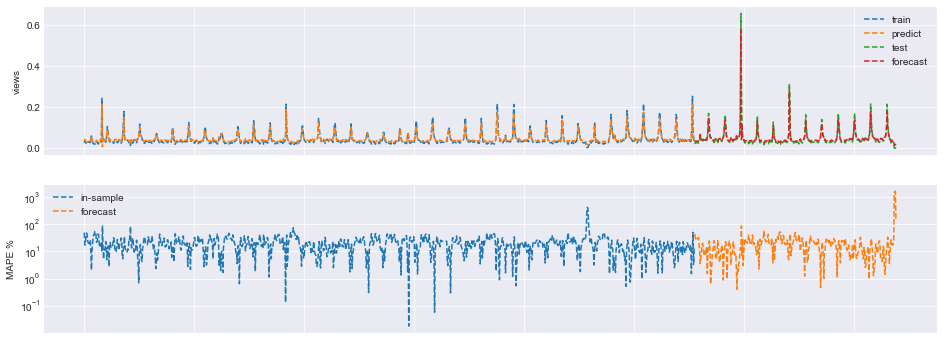

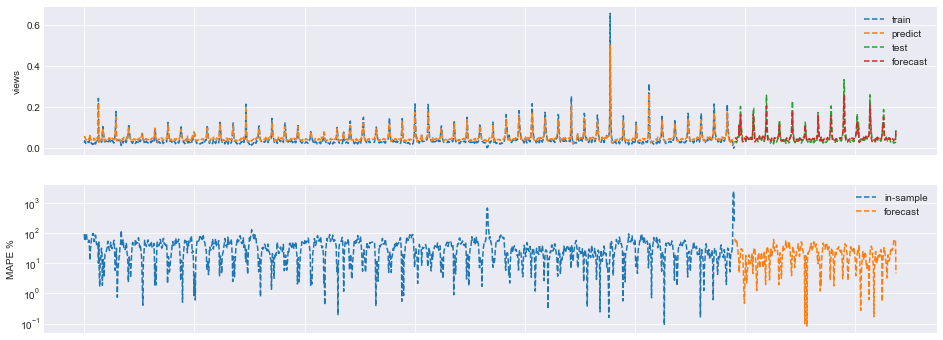

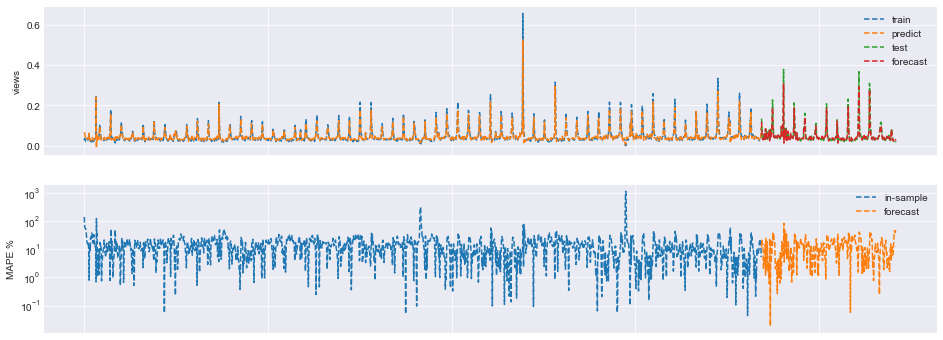

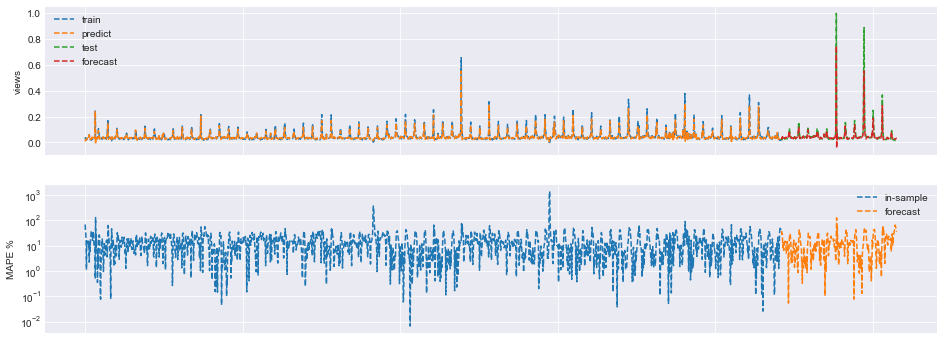

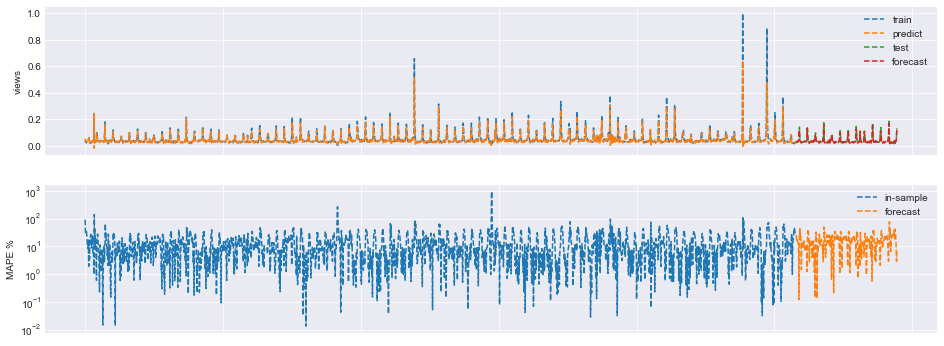

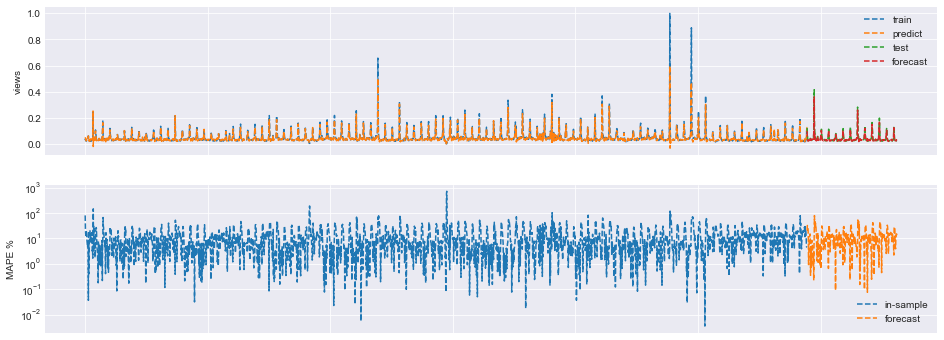

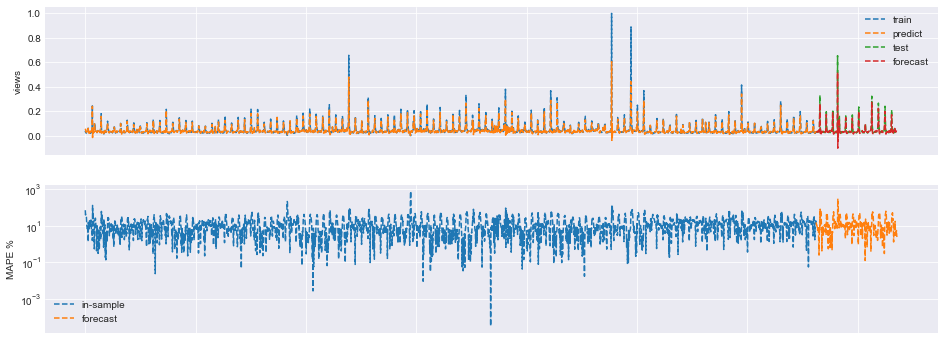

In [24]:
n_years, n_neurons, n_epoch, batch_size= 10, 4, 10, 1
# n_years, n_neurons, n_epoch, batch_size= 3, 4, 2, 1
lstm_cv_errors = CV_LSTM(X_scaled, Y_scaled, n_years, n_neurons, n_epoch, batch_size)

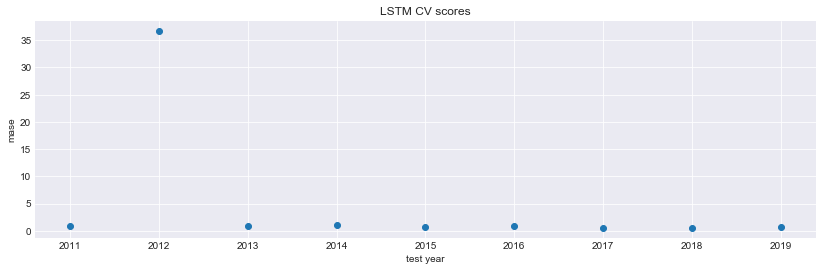

In [25]:
plt.figure(figsize=(14, 4))

plt.plot(np.arange(len(lstm_cv_errors['mase'])), lstm_cv_errors['mase'], 'o')
plt.xticks(np.arange(len(lstm_cv_errors['mase'])).tolist(), np.arange(2011, 2011+len(lstm_cv_errors['mase'])).tolist())
plt.xlabel('test year')
plt.ylabel('mase')
plt.title('LSTM CV scores');

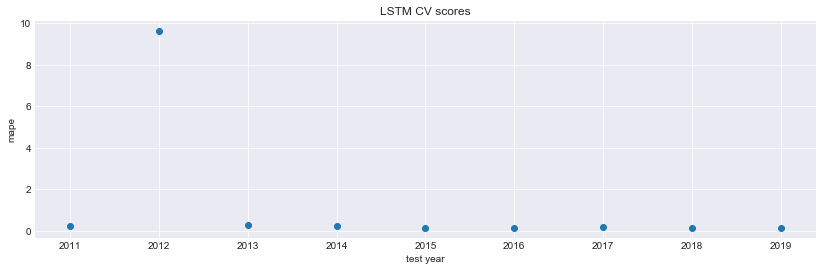

In [26]:
plt.figure(figsize=(14, 4))

plt.plot(np.arange(len(lstm_cv_errors['mape'])), lstm_cv_errors['mape'], 'o')
plt.xticks(np.arange(len(lstm_cv_errors['mape'])).tolist(), np.arange(2011, 2011+len(lstm_cv_errors['mape'])).tolist())
plt.xlabel('test year')
plt.ylabel('mape')
plt.title('LSTM CV scores');

In [27]:
n_neurons, n_epoch, batch_size= 4, 10, 1
lstm = Fit_LSTM(X_scaled, Y_scaled, n_neurons, n_epoch, batch_size)

y_pred_scaled = lstm.predict(X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1]), batch_size=1)
y_pred = minmax_scaler.inverse_transform(y_pred_scaled)

residual = y_pred - Y

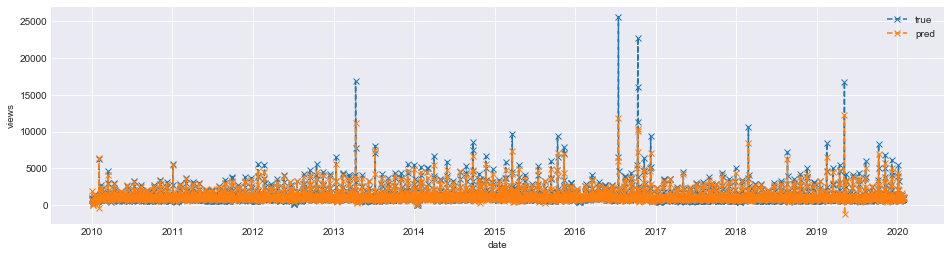

In [28]:
plt.figure(figsize=(16, 4))

plt.plot(np.arange(len(X)), X, 'x--', label='true')
plt.plot(np.arange(len(X)), y_pred, 'x--', label='pred')

plt.xticks(np.arange(0, len(fullmoon), 365).tolist(), np.arange(2010, 2021).tolist())
plt.xlabel('date')
plt.ylabel('views')
plt.legend();

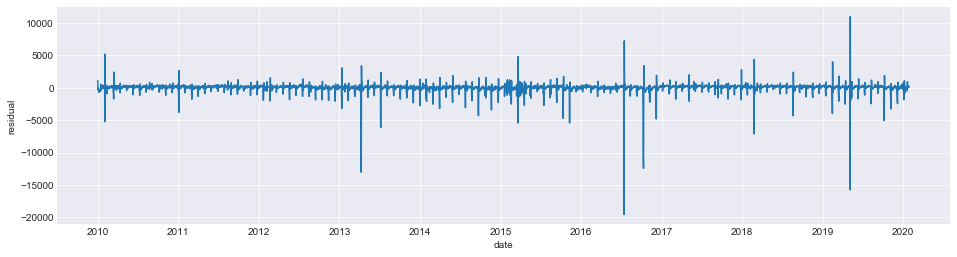

In [29]:
plt.figure(figsize=(16, 4))

plt.plot(np.arange(len(residual)), residual)
plt.xlabel('date')
plt.ylabel('residual')
plt.xticks(np.arange(0, len(fullmoon), 365).tolist(), np.arange(2010, 2021).tolist());

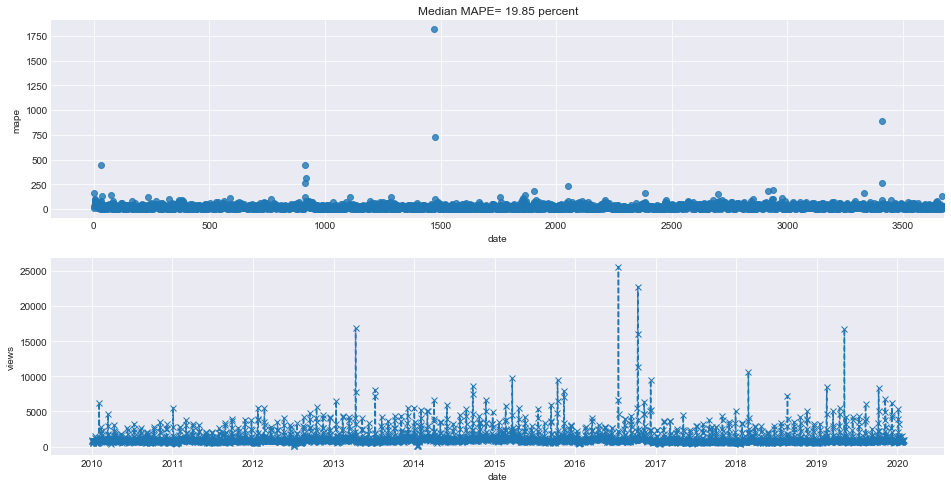

In [30]:
mape = 100.0*np.abs(residual)/Y

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

sns.regplot(x=np.arange(len(mape)), y=mape.squeeze(), ax=axes[0])
axes[0].set_xlabel('date')
axes[0].set_ylabel('mape')
axes[0].set_title('Median MAPE= %0.2f percent' % np.median(mape))
plt.xticks(np.arange(0, len(fullmoon), 365).tolist(), np.arange(2010, 2021).tolist())

axes[1].plot(np.arange(len(X)), X, 'x--', label='true')
plt.xticks(np.arange(0, len(fullmoon), 365).tolist(), np.arange(2010, 2021).tolist())
axes[1].set_xlabel('date')
axes[1].set_ylabel('views');

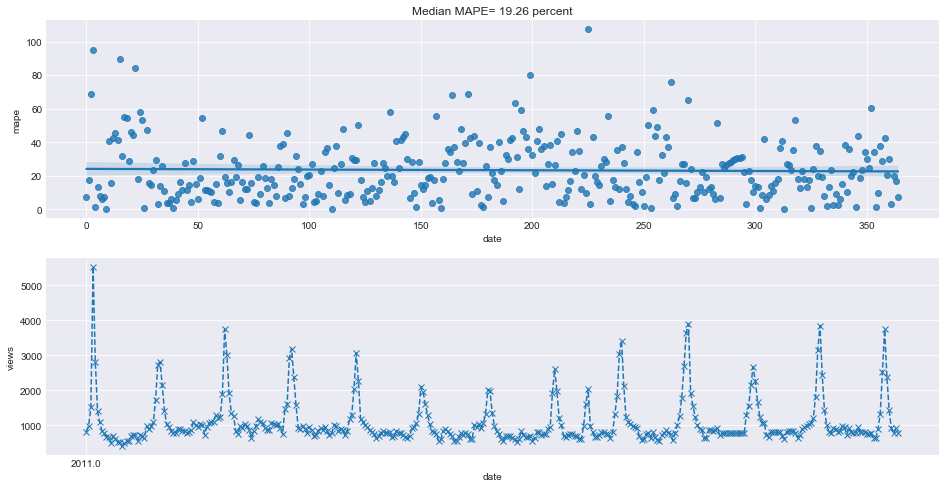

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

i_first, i_last = 365, 365*2

sns.regplot(x=np.arange(len(mape[i_first:i_last])), y=mape[i_first:i_last].squeeze(), ax=axes[0])
axes[0].set_xlabel('date')
axes[0].set_ylabel('mape')
axes[0].set_title('Median MAPE= %0.2f percent' % np.median(mape[i_first:i_last]))

axes[1].plot(np.arange(len(X[i_first:i_last])), X[i_first:i_last], 'x--', label='true')
plt.xticks(np.arange(0, len(X[i_first:i_last]), 365).tolist(), 
           np.arange(int(i_first)/365+2010, int(i_first)/365+2010+len(X[i_first:i_last])).tolist())
axes[1].set_xlabel('date')
axes[1].set_ylabel('views');